# Introduction

This notebook shows an example of relaxing the LiFePO4 crystal.

If you are running this notebook from Google Colab, uncomment the next code box to install m3gnet first.

In [ ]:
# !pip install m3gnet
# !pip install ase
# !pip install pymatgen

In [ ]:
import warnings

import numpy as np
from pymatgen.ext.matproj import MPRester
from pymatgen.util.coord import pbc_diff

from m3gnet.models import Relaxer

for category in (UserWarning, DeprecationWarning):
    warnings.filterwarnings("ignore", category=category, module="tensorflow")

In [ ]:
mpr = MPRester("4HmCPQXiVVZmUjfuKNJSgE0G6MPLfTAA")
lfp = mpr.get_structure_by_material_id("mp-19017")  # This is LiFePO4.

lfp_strained = lfp.copy()  # We create a copy.
# Create a random strain between -5% and 5% for each direction
strains = np.random.uniform(low=-0.05, high=0.05, size=3)
lfp_strained.apply_strain(strains)
# In addition to the lattice strains, we also perturb the atoms by a distance of 0.1 angstrom.
lfp_strained.perturb(0.1)

/usr/local/lib/python3.10/dist-packages/mp_api/client/mprester.py:193: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
relaxer = Relaxer()
relax_results: dict
%time relax_results = relaxer.relax(lfp_strained)
relaxed_struct = relax_results["final_structure"]

CPU times: user 36 s, sys: 11.7 s, total: 47.6 s
Wall time: 43.1 s


Note that the relaxation only took < 20s.

The relaxation using the M3GNet universal IAP has brought the lattice parameters much closer to the original DFT ones and the coordinates are also within $10^{-3}$ of the original fractional coordinates.

In [ ]:
print(f"Original lattice parameters are {[round(x, 3) for x in lfp.lattice.abc]}")
print(f"Strained lattice parameters are {[round(x, 3) for x in lfp_strained.lattice.abc]}")
print(f"Relaxed lattice parameters are {[round(x, 3) for x in relaxed_struct.lattice.abc]}")

Original lattice parameters are [10.236, 5.971, 4.655]
Strained lattice parameters are [9.954, 6.233, 4.776]
Relaxed lattice parameters are [10.439, 6.1, 4.752]


In [ ]:
lfp_strained.frac_coords

array([[0.9903993 , 0.00114544, 0.00598492],
       [0.50194289, 0.48617413, 0.50981972],
       [0.50161988, 0.00222787, 0.47953985],
       [0.99658164, 0.50706479, 0.01739777],
       [0.77214799, 0.25170305, 0.52084376],
       [0.72743754, 0.74414641, 0.02214501],
       [0.27757935, 0.26243236, 0.98107566],
       [0.21879512, 0.7655097 , 0.46477945],
       [0.09656114, 0.25573149, 0.43735655],
       [0.40530703, 0.75731526, 0.93717998],
       [0.60289285, 0.25620875, 0.07703445],
       [0.89927153, 0.75551128, 0.5948732 ],
       [0.09113114, 0.23718995, 0.73396135],
       [0.82478456, 0.54142164, 0.71901949],
       [0.82752029, 0.95362835, 0.72942424],
       [0.91578336, 0.75051077, 0.25364042],
       [0.0397918 , 0.76421147, 0.71226901],
       [0.40063611, 0.74852221, 0.22688911],
       [0.16556039, 0.04998456, 0.26614753],
       [0.67396954, 0.46313269, 0.21853913],
       [0.34084011, 0.55451424, 0.77589023],
       [0.33298509, 0.96794708, 0.77522639],
       [0.

In [ ]:
strained_to_orig_frac_coords_mean_diff = abs(pbc_diff(lfp_strained.frac_coords, lfp.frac_coords)).mean()

print(
    "mean diff in frac. coords. between strained and original "
    f"LFP structure: {strained_to_orig_frac_coords_mean_diff:.3}"
)

mean diff in frac. coords. between strained and original LFP structure: 0.00774


In [ ]:
orig_to_m3gnet_frac_coords_mean_diff = abs(pbc_diff(lfp.frac_coords, relaxed_struct.frac_coords)).mean()

print(
    "mean diff in frac. coords. between original and M3GNet-relaxed "
    f"LFP structure: {orig_to_m3gnet_frac_coords_mean_diff:.3}"
)

mean diff in frac. coords. between original and M3GNet-relaxed LFP structure: 0.00342


In [ ]:
mean_pbc_diff_ratio = strained_to_orig_frac_coords_mean_diff / orig_to_m3gnet_frac_coords_mean_diff

print(
    f"M3GNet reduces the mean difference in frac. coords. from the strained "
    f"to the original structure by a factor of: {mean_pbc_diff_ratio:.3}"
)

M3GNet reduces the mean difference in frac. coords. from the strained to the original structure by a factor of: 2.26


# Phonon Band Structure and DOS

The M3GNet IAP can also be used to compute the lattice vibrations in a super cell.

In [ ]:
from ase.phonons import Phonons
from pymatgen.io.ase import AseAtomsAdaptor

from m3gnet.models import M3GNet, M3GNetCalculator, Potential

mp_129 = mpr.get_structure_by_material_id(mp_id := "mp-129")

# Setup crystal and EMT calculator
atoms = AseAtomsAdaptor().get_atoms(mp_129)

potential = Potential(M3GNet.load())

calculator = M3GNetCalculator(potential=potential, stress_weight=0.01)

# Phonon calculator
N = 7
supercell = (N, N, N)
ph = Phonons(atoms, calculator, supercell=supercell, delta=0.05)
ph.run()

# Read forces and assemble the dynamical matrix
ph.read(acoustic=True)
ph.clean()

path = atoms.cell.bandpath("GHPGN", npoints=100)
bs = ph.get_band_structure(path)

dos = ph.get_dos(kpts=(20, 20, 20)).sample_grid(npts=100, width=1e-3)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

WARNING, 2 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 5.987e-09*i)
WARNING, 2 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 5.987e-09*i)


Text(0.5, 1.02, 'Phonon band structure and DOS of LiFePO4 Mo1 (mp-129) with (7, 7, 7) supercell')

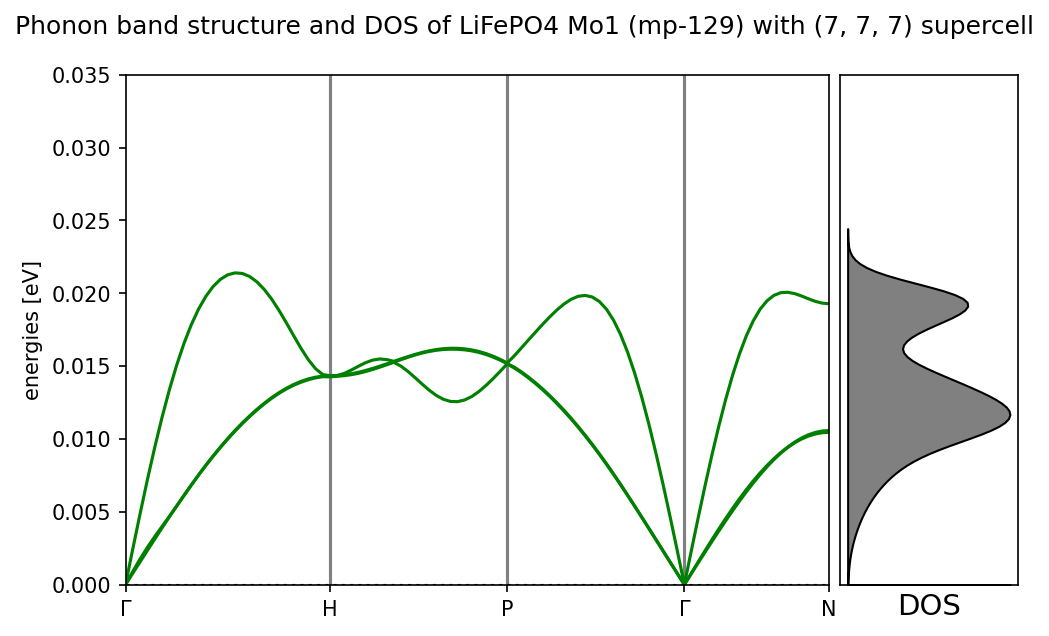

In [ ]:
# Plot the band structure and DOS:
import matplotlib.pyplot as plt

plt.rc("figure", dpi=150)

fig = plt.figure(1, figsize=(7, 4))
bs_ax = fig.add_axes([0.12, 0.07, 0.67, 0.85])

emax = 0.035
bs.plot(ax=bs_ax, emin=0.0, emax=emax)

dos_ax = fig.add_axes([0.8, 0.07, 0.17, 0.85])
dos_ax.fill_between(dos.get_weights(), dos.get_energies(), y2=0, color="grey", edgecolor="black", lw=1)

dos_ax.set_ylim(0, emax)
dos_ax.set_yticks([])
dos_ax.set_xticks([])
dos_ax.set_xlabel("DOS", fontsize=14)

fig.suptitle(
    f"Phonon band structure and DOS of LiFePO4 {mp_129.formula} ({mp_id}) with {supercell} supercell",
    fontsize=12,
    y=1.02,
)